### KDD 2022 Hands-on Tutorial on "Gradual AutoML using Lale"


# 7. Working with Multi-table Datasets

The preprocessing steps in a data science workflow often involve more than one table.
Data scientists usually write independent scripts for such data preparation as there is no easy way to include it in a machine learning pipeline.
Lale introduced preprocessing operators for performing join, filter, map, groupby, aggregate, etc. as part of end-to-end sklearn-style pipelines.
We will demonstrate these operators in the context of a classification task.

This tutorial has the following sections:

-   [7.1 Dataset](#dataset)
-	[7.2 Lale Operators for Multi-table Handling](#laleoperators)
-	[7.3 End-to-End Classification Pipeline](#classification)
-	[7.4 Summary](#summary)

<a id="dataset"></a>
## 7.1 Dataset

This notebook uses a multi-table variant of the [credit-g](https://www.openml.org/d/31) dataset from OpenML.
For demonstration purposes, we have split the dataset into three tables: `loan_application`, `bank_account_info` and `existing_credits_info`.
The table `loan_application` serves as our primary table, and we treat the other two tables as providing additional information related to the applicant's bank account and existing credits.
This resembles a real life scenario where information is present in multiple tables in normalized forms.
We created a primary key column `id` as a proxy to the loan applicant's identity number.

You can access the dataset by invoking the `fetch_creditg_multitable_dataset` function from `lale.datasets.multitable`.
It returns a list of `lale.datasets.data_schemas.DataFrameWithSchema` objects, which are pandas dataframes with additional information such as `table_name`.

In [1]:
from lale.datasets.multitable import fetch_creditg_multitable_dataset
tables_list = fetch_creditg_multitable_dataset()

Let's inspect the dataset:

In [2]:
from lale.datasets.data_schemas import get_table_name
import pandas as pd
from IPython.display import display

for table in tables_list:
    print(f'\nTable `{get_table_name(table)}` of type {type(table)}:')
    display(table)


Table `bank_account_info` of type <class 'lale.datasets.data_schemas.DataFrameWithSchema'>:


,id,checking_status,savings_status
863,863,no checking,>=1000
748,748,no checking,no known savings
64,64,no checking,<100
798,798,no checking,no known savings
52,52,no checking,<100
...,...,...,...
76,76,<0,<100
48,48,no checking,<100
503,503,0<=X<200,100<=X<500
263,263,no checking,<100



Table `loan_application` of type <class 'lale.datasets.data_schemas.DataFrameWithSchema'>:


,id,duration,credit_history,purpose,credit_amount,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,job,num_dependents,own_telephone,foreign_worker,class
863,863,27.0,critical/other existing credit,furniture/equipment,4526.0,<1,4.0,male single,none,2.0,real estate,32.0,stores,own,unskilled resident,2.0,yes,yes,good
748,748,21.0,existing paid,used car,5248.0,1<=X<4,1.0,male single,none,3.0,car,26.0,none,own,skilled,1.0,none,yes,good
64,64,24.0,existing paid,radio/tv,3181.0,<1,4.0,female div/dep/mar,none,4.0,life insurance,26.0,none,own,skilled,1.0,yes,yes,good
798,798,24.0,delayed previously,new car,717.0,>=7,4.0,male mar/wid,none,4.0,car,54.0,none,own,skilled,1.0,yes,yes,good
52,52,12.0,existing paid,radio/tv,1262.0,1<=X<4,3.0,male single,none,2.0,car,25.0,none,own,skilled,1.0,none,yes,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,76,42.0,existing paid,radio/tv,3965.0,<1,4.0,male single,none,3.0,car,34.0,none,own,skilled,1.0,none,yes,bad
48,48,11.0,critical/other existing credit,new car,7228.0,1<=X<4,1.0,male single,none,4.0,life insurance,39.0,none,own,unskilled resident,1.0,none,yes,good
503,503,24.0,critical/other existing credit,radio/tv,1216.0,<1,4.0,male single,none,4.0,no known property,38.0,bank,own,skilled,2.0,none,yes,bad
263,263,12.0,critical/other existing credit,education,2748.0,>=7,2.0,female div/dep/mar,none,4.0,no known property,57.0,bank,for free,unskilled resident,1.0,none,yes,good



Table `existing_credits_info` of type <class 'lale.datasets.data_schemas.DataFrameWithSchema'>:


,id,credit_number,type,status
0,863,849100,credit,on
1,863,213390,credit,on
2,748,682637,credit,on
3,64,623110,credit,on
4,798,71947,credit,on
...,...,...,...,...
1402,503,76140,credit,on
1403,263,882716,credit,on
1404,263,93342,credit,on
1405,263,825936,credit,on


<a id="laleoperators"></a>
## 7.2 Lale Operators for Multi-table Handling

Lale has a [number of operators](https://lale.readthedocs.io/en/latest/modules/lale.lib.rasl.html#relational-algebra-operators) that correspond to relational algebra operations such as `Join`, `GroupBy`, `Aggregate`, etc.
These allow joining multiple tables and creating new features after the join by performing groupby and aggregate or doing preprocessing such as filter, project, etc.

In this example, we will join the `loan_application` and `bank_account_info` using equi-join based on `id`.
We will then join the `loan_application` and `existing_credits_info` and re-create the `existing_credits` column from the original single table dataset by counting the number of credits per id from the join output.

In [3]:
from lale.lib.rasl import Scan, Join, GroupBy, Aggregate
from lale.expressions import it, count

[`Scan`](https://lale.readthedocs.io/en/latest/modules/lale.lib.rasl.scan.html?highlight=Scan#lale.lib.rasl.scan.Scan) allows us to read a single dataframe from the list and outputs of multiple `Scans` combined using `&` can be the input to [`Join`](https://lale.readthedocs.io/en/latest/modules/lale.lib.rasl.join.html?highlight=Join#lale.lib.rasl.join.Join). `Join` takes a list of join predicates as a hyperparameter. Note the use of `it.<table_name>` and `it.<table_name>.<column_name>` which are special expressions defined by Lale with a keyword `it`.

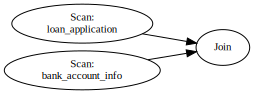

In [4]:
join_bank_info = (
       (Scan(table=it.loan_application) & Scan(table=it.bank_account_info))
    >> Join(pred=[it.loan_application.id == it.bank_account_info.id])
)
join_bank_info.visualize()

[`GroupBy`](https://lale.readthedocs.io/en/latest/modules/lale.lib.rasl.group_by.html?highlight=GroupBy#lale.lib.rasl.group_by.GroupBy) expects a list of group by expressions and it has to be followed by [`Aggregate`](https://lale.readthedocs.io/en/latest/modules/lale.lib.rasl.aggregate.html). `Aggregate` expects a dictionary with the name of the column being created as the key and an aggregate function. Here, we re-create the `existing_credits` count column by using [`count`](https://lale.readthedocs.io/en/latest/modules/lale.expressions.html?highlight=it#lale.expressions.count) as an aggregate function. Other functions that can be used with `Aggregate` are listed [here](https://lale.readthedocs.io/en/latest/modules/lale.expressions.html?highlight=it#module-lale.expressions).

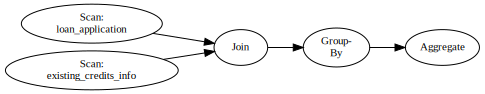

In [5]:
existing_credit_feature = (
       (Scan(table=it.loan_application) & Scan(table=it.existing_credits_info))
    >> Join(pred=[it.loan_application.id == it.existing_credits_info.id])
    >> GroupBy(by=[it.id]) #primary key of main table
    >> Aggregate(columns={'existing_credits': count(it.credit_number)})
)
existing_credit_feature.visualize()

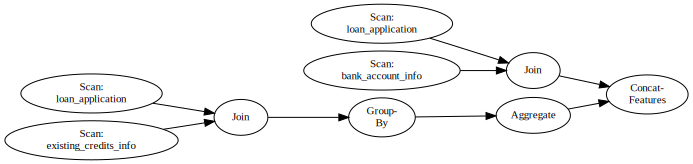

In [6]:
from lale.lib.lale import ConcatFeatures

all_features = (
    (join_bank_info & existing_credit_feature)
    >> ConcatFeatures
)
all_features.visualize()

In [7]:
df = all_features.transform(tables_list)
df

,id,duration,credit_history,purpose,credit_amount,employment,installment_commitment,personal_status,other_parties,residence_since,...,other_payment_plans,housing,job,num_dependents,own_telephone,foreign_worker,class,checking_status,savings_status,existing_credits
0,863,27.0,critical/other existing credit,furniture/equipment,4526.0,<1,4.0,male single,none,2.0,...,stores,own,unskilled resident,2.0,yes,yes,good,no checking,>=1000,2
1,748,21.0,existing paid,used car,5248.0,1<=X<4,1.0,male single,none,3.0,...,none,own,skilled,1.0,none,yes,good,no checking,no known savings,1
2,64,24.0,existing paid,radio/tv,3181.0,<1,4.0,female div/dep/mar,none,4.0,...,none,own,skilled,1.0,yes,yes,good,no checking,<100,1
3,798,24.0,delayed previously,new car,717.0,>=7,4.0,male mar/wid,none,4.0,...,none,own,skilled,1.0,yes,yes,good,no checking,no known savings,1
4,52,12.0,existing paid,radio/tv,1262.0,1<=X<4,3.0,male single,none,2.0,...,none,own,skilled,1.0,none,yes,good,no checking,<100,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,76,42.0,existing paid,radio/tv,3965.0,<1,4.0,male single,none,3.0,...,none,own,skilled,1.0,none,yes,bad,<0,<100,1
996,48,11.0,critical/other existing credit,new car,7228.0,1<=X<4,1.0,male single,none,4.0,...,none,own,unskilled resident,1.0,none,yes,good,no checking,<100,1
997,503,24.0,critical/other existing credit,radio/tv,1216.0,<1,4.0,male single,none,4.0,...,bank,own,skilled,2.0,none,yes,bad,0<=X<200,100<=X<500,1
998,263,12.0,critical/other existing credit,education,2748.0,>=7,2.0,female div/dep/mar,none,4.0,...,bank,for free,unskilled resident,1.0,none,yes,good,no checking,<100,1


<a id="classification"></a>
## 7.3 End-to-End Classification Pipeline

The pipeline that created the new features can be used for a downstream task by adding it as a prefix to the task pipeline. In this example, we will build a combined classification pipeline. Creating an end-to-end pipeline has many advantages such as ease of maintenance, no data leakage, and consistent operations for training and predicting.

For the end-to-end classification pipeline for `credit-g` classification task, the operations on the multi-table dataset to create new features form the prefix, we then use the data preprocessing pipeline similar to the one used in the tutorial notebook [Customizing Algorithm Choices and Hyperparameters](./03_custom.ipynb) and finally, [XGBClassifier](https://lale.readthedocs.io/en/latest/modules/lale.lib.xgboost.xgb_classifier.html?highlight=XGBClassifier#lale.lib.xgboost.xgb_classifier.XGBClassifier) for classification.

Please note that we need to drop the `id` column from the joined dataset, and we can use the [Project](https://lale.readthedocs.io/en/latest/modules/lale.lib.rasl.project.html?highlight=Project#lale.lib.rasl.project.Project) operator to drop that column.
Also, we have been working with a single table containing all the features as well as the class label. The `fit` API of XGBClassifier expects them separately, so we will use the [SplitXy](https://lale.readthedocs.io/en/latest/modules/lale.lib.rasl.split_xy.html?highlight=SplitXy#lale.lib.rasl.split_xy.SplitXy) operator to split the dataset into `X` and `y`.

In [8]:
from lale.lib.lale import Project, SplitXy
from lale.lib.sklearn import OrdinalEncoder, SimpleImputer
from lale.lib.xgboost import XGBClassifier

cat_enc = Project(columns={"type": "string"}) >> OrdinalEncoder(handle_unknown="ignore")
num = Project(columns={"type": "number"}) >> SimpleImputer()
preprocessing = (cat_enc & num) >> ConcatFeatures()

classification_pipeline = (all_features 
                            >> Project(drop_columns=['id'])
                            >> SplitXy(label_name='class')
                            >> preprocessing
                            >> XGBClassifier())

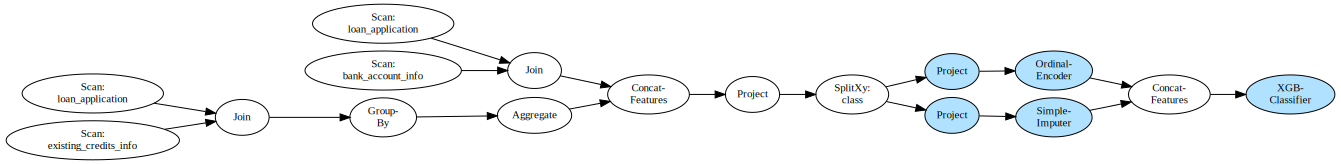

In [9]:
classification_pipeline.visualize()

In [10]:
trained_pipeline = classification_pipeline.fit(tables_list)

In [11]:
predictions = trained_pipeline.predict(tables_list)
print(list(predictions)[:12])

['good', 'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'bad', 'good', 'bad', 'good']


<a id="summary"></a>
## 7.4 Summary

Lale has several relational algebra based operators for feature engineering from multi-table datasets.
We demonstrated some of them in this tutorial and a complete list can be found at the documentation for [lale.lib.rasl](https://lale.readthedocs.io/en/latest/modules/lale.lib.rasl.html#module-lale.lib.rasl).

The following paper describes the design of relational algebra operators in Lale.

```bibtex
    @InProceedings{sahni_et_al_2021,
      title = "{RASL}: Relational Algebra in Scikit-Learn Pipelines",
      author = "Sahni, Chirag and Kate, Kiran and Shinnar, Avraham and Lam, Hoang Thanh and Hirzel, Martin",
      booktitle = "Workshop on Databases and AI (DBAI@NeurIPS)",
      year = 2021,
      month = dec,
      url = "https://openreview.net/forum?id=u9ct1gjoDcn" }
```

In this tutorial, the dataset was read as a list of pandas dataframes and hence most operations invoked pandas APIs, but the operators from `lale.lib.rasl` also have a Spark backend. The paper above discusses the multiple backends as well as a comparison of the runtime performance of the two backends on a real-life dataset.